# Análise de dados do Ar

## Fonte dos dados
[Air Quality Open Data Platform](https://aqicn.org/data-platform/covid19/)

The data for each major cities is based on the average (median) of several stations. The data set provides min, max, median and standard deviation for each of the air pollutant species (PM2.5,PM10, Ozone ...) as well as meteorological data (Wind, Temperature, ...). All air pollutant species are converted to the US EPA standard (i.e. no raw concentrations). All dates are UTC based. The count column is the number of samples used for calculating the median and standard deviation.

In [1]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import json
pd.set_option('display.max_columns', None)

# use glob to get all the csv files
# in the folder
path = os.path.abspath('../data/air-quality')
csv_files = glob.glob(os.path.join(path, "*.csv"))

# loop over the list of csv files
df_raw = pd.DataFrame()
for f in csv_files:
    df_tmp = pd.read_csv(f,comment='#')
    df_raw = pd.concat([df_raw, df_tmp])

In [2]:
df_raw.columns = df_raw.columns.str.upper()

Buscando informações sobre as cidades

In [3]:
cities_data = []
with open('../data/air-quality/airquality-covid19-cities.json', encoding="utf-8") as json_file:
    cities_data = json.load(json_file)['data']

In [4]:
print(len(df_raw), "Rows")
print(len(cities_data), "Cities")

10124378 Rows
618 Cities


In [5]:
df_raw.head(3)

,DATE,COUNTRY,CITY,SPECIE,COUNT,MIN,MAX,MEDIAN,VARIANCE
0,2015-01-06,KR,Jeonju,co,124,0.1,12.3,4.5,55.74
1,2015-01-22,KR,Jeonju,co,116,4.5,10.0,6.7,16.09
2,2015-03-30,KR,Jeonju,co,118,1.2,11.2,5.6,35.98


In [6]:
df_raw.describe(include="all")

,DATE,COUNTRY,CITY,SPECIE,COUNT,MIN,MAX,MEDIAN,VARIANCE
count,10124378,10124378,10124378,10124378,1.012438e+07,1.012438e+07,1.012438e+07,1.012438e+07,1.012438e+07
unique,2106,95,616,24,NaN,NaN,NaN,NaN,NaN
top,2020-01-05,CN,London,pm25,NaN,NaN,NaN,NaN,NaN
freq,14200,1049342,36307,992557,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.277638e+02,8.998309e+01,1.235257e+02,1.029449e+02,6.404836e+03
std,NaN,NaN,NaN,NaN,1.809249e+02,2.715001e+02,2.750709e+02,2.704365e+02,2.063434e+05
min,NaN,NaN,NaN,NaN,2.000000e+00,-3.276600e+03,-3.065600e+03,-3.065600e+03,0.000000e+00
25%,NaN,NaN,NaN,NaN,4.400000e+01,1.000000e+00,1.060000e+01,4.200000e+00,2.225000e+01
50%,NaN,NaN,NaN,NaN,7.200000e+01,4.500000e+00,2.850000e+01,1.400000e+01,1.429300e+02
75%,NaN,NaN,NaN,NaN,1.440000e+02,2.000000e+01,7.890000e+01,3.960000e+01,8.826700e+02


In [7]:
df_raw.dtypes

DATE         object
COUNTRY      object
CITY         object
SPECIE       object
COUNT         int64
MIN         float64
MAX         float64
MEDIAN      float64
VARIANCE    float64
dtype: object

## Convertendo data e filtrando

In [8]:
df_raw['DATE'] = pd.to_datetime(df_raw['DATE'], format='%Y-%m-%d')

### Tipos de gases/fênomenos no ar

In [9]:
species_list = df_raw['SPECIE'].unique()
print(species_list)

['co' 'pm10' 'o3' 'so2' 'no2' 'pm25' 'psi' 'uvi' 'neph' 'aqi' 'mepaqi'
 'pol' 'temperature' 'humidity' 'pressure' 'wd' 'wind-speed' 'd' 'pm1'
 'wind-gust' 'precipitation' 'dew' 'wind speed' 'wind gust']


***Desejados***
 - Monóxido de Carbono -> Queima incompleta de combustíveis derivados de petróleo, ou seja, substâncias ricas em carbono.
 - Partículas com diâmetro inferior a 25 micrómetros
 - Partículas com diâmetro inferior a 10 micrómetros
 - Partículas com diâmetro inferior a 1 micrómetros
 - Ozônio -> Aquecimento global
 - Dióxido de enxofre -> Chuvas Ácidas
 - Dióxido de nitrogénio -> Chuvas Ácidas

In [10]:
species_list = ['co', 'pm25', 'pm10', 'pm1', 'o3', 'so2', 'no2']

Filtrando só os gases que importam para a análise

In [11]:
df = df_raw[df_raw[['SPECIE']].isin(species_list).any(axis=1)]

In [12]:
print(len(df), "Rows")

5454515 Rows


### Removendo nulos

In [22]:
df[df['MEDIAN'].isna()]

,DATE,COUNTRY,CITY,SPECIE,COUNT,MIN,MAX,MEDIAN,VARIANCE


In [23]:
df[df['MEDIAN'].isnull()]

,DATE,COUNTRY,CITY,SPECIE,COUNT,MIN,MAX,MEDIAN,VARIANCE


In [13]:
df = df.drop(df[df.MEDIAN == 999.0].index)

no2 -> industrial


crescer economicamente significa gerar efeito estufa?
quem se desenvolveu economicamente tá relacionado com o momento

poluição x efeito estufa
entender em relação aos CONTINENTES


adicionar dados socio economicos
fazer análise entre países ricos, países pobres e depois entender os dois juntos

In [14]:
df_by_year_specie = df.groupby([df.DATE.dt.year, df.COUNTRY, df.SPECIE])['MEDIAN'].mean().rename('MEAN_BY_COUNTRY_SPECIE').reset_index()
df_by_year_specie

,DATE,COUNTRY,SPECIE,MEAN_BY_COUNTRY_SPECIE
0,2014,AT,co,0.100000
1,2014,AT,no2,17.886667
2,2014,AT,pm10,24.200000
3,2014,AT,pm25,83.000000
4,2014,AT,so2,2.100000
...,...,...,...,...
3185,2022,ZA,no2,5.744677
3186,2022,ZA,o3,6.441432
3187,2022,ZA,pm10,31.297930
3188,2022,ZA,pm25,57.365116


In [15]:
df_by_year = df.groupby([df.DATE.dt.year, df.COUNTRY])['MEDIAN'].mean().rename('MEAN_BY_COUNTRY').reset_index()
df_by_year

,DATE,COUNTRY,MEAN_BY_COUNTRY
0,2014,AT,17.610606
1,2014,AU,19.197080
2,2014,BE,22.404902
3,2014,BO,9.266667
4,2014,BR,15.451852
...,...,...,...
671,2022,US,15.708831
672,2022,UZ,88.309392
673,2022,VN,20.090321
674,2022,XK,24.989985


In [56]:
df_by_year.query('COUNTRY == "AF"')

,DATE,COUNTRY,MEAN_BY_COUNTRY
309,2019,AF,194.142857
400,2020,AF,110.493404
494,2021,AF,115.468619


In [57]:
df_by_year_pivot = df_by_year.pivot(index='DATE', columns='COUNTRY', values='MEAN_BY_COUNTRY')
df_by_year_pivot

COUNTRY,AE,AF,AR,AT,AU,BA,BD,BE,BG,BH,BO,BR,CA,CH,CI,CL,CN,CO,CR,CW,CY,CZ,DE,DK,DZ,EC,EE,ES,ET,FI,FR,GB,GE,GH,GN,GR,GT,HK,HR,HU,ID,IE,IL,IN,IQ,IR,IS,IT,JO,JP,KG,KR,KW,KZ,LA,LK,LT,MK,ML,MM,MN,MO,MX,NL,NO,NP,NZ,PE,PH,PK,PL,PR,PT,RE,RO,RS,RU,SA,SE,SG,SK,SV,TH,TJ,TM,TR,TW,UA,UG,US,UZ,VN,XK,ZA
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014,NaN,NaN,NaN,17.610606,19.197080,NaN,NaN,22.404902,NaN,NaN,9.266667,15.451852,9.589247,16.400000,NaN,22.327103,54.207859,14.338889,NaN,NaN,24.359259,30.972464,12.814894,53.825000,NaN,NaN,NaN,15.691837,NaN,14.821053,25.338068,25.413768,NaN,NaN,NaN,NaN,NaN,35.494444,12.103125,13.676712,NaN,NaN,28.617000,80.352000,NaN,NaN,NaN,24.890411,NaN,23.878636,NaN,26.305298,NaN,NaN,NaN,NaN,19.060000,NaN,NaN,NaN,60.417647,47.650000,31.478947,22.395333,21.513333,NaN,NaN,37.860000,NaN,NaN,25.875587,NaN,15.206667,7.713333,NaN,NaN,11.261111,NaN,NaN,11.150000,17.887500,98.333333,19.470930,NaN,NaN,15.571429,35.404321,NaN,NaN,14.154082,NaN,36.550000,NaN,7.283333
2015,46.011019,NaN,12.732283,12.921702,34.418689,NaN,NaN,18.876610,18.270536,NaN,15.675668,17.022074,13.320819,17.956917,NaN,38.418730,42.086491,22.016776,NaN,NaN,19.245345,25.388046,14.919127,17.368254,NaN,18.555655,NaN,14.421927,NaN,14.367717,21.730934,18.770909,NaN,NaN,NaN,NaN,40.418868,27.127601,13.361243,12.674808,69.800000,NaN,27.909464,51.945830,NaN,47.918860,6.600000,29.136854,NaN,19.791879,NaN,28.438450,NaN,NaN,NaN,NaN,17.648515,22.316667,NaN,NaN,45.913889,29.424515,24.627378,20.446454,15.812710,NaN,10.458333,23.120364,NaN,NaN,20.128011,NaN,20.142569,7.170691,14.310588,12.030691,16.052813,NaN,15.736531,17.108379,22.652054,106.651934,17.510411,NaN,NaN,21.979775,25.493801,NaN,NaN,17.366545,NaN,21.061054,NaN,13.309211
2016,18.200473,NaN,15.074651,11.424322,10.120175,33.316250,132.201613,17.426334,11.826503,138.500000,21.556359,16.868733,11.785910,9.086320,NaN,36.656781,39.157395,46.174169,NaN,NaN,18.389715,23.183249,15.029056,17.331754,NaN,21.519090,NaN,12.829426,56.000000,15.522435,19.015246,18.441104,NaN,NaN,NaN,NaN,NaN,23.966755,10.996992,11.184550,99.125541,NaN,27.486939,46.252135,NaN,44.591476,8.891005,27.076767,NaN,18.766578,NaN,28.902547,NaN,NaN,NaN,NaN,14.499409,22.752618,NaN,NaN,44.816755,27.027866,24.661608,18.520767,18.544741,125.500000,13.210485,29.460758,NaN,NaN,20.809978,NaN,16.395077,11.862918,12.550021,20.736387,15.284722,NaN,18.790194,17.502028,17.971576,89.307229,21.178592,NaN,NaN,26.039244,24.358637,NaN,NaN,16.463398,NaN,45.349770,50.679612,11.166412
2017,NaN,NaN,17.675524,13.010520,10.847275,23.045983,155.298343,19.825862,19.209712,128.404762,15.797680,14.964679,11.504523,12.118231,NaN,34.086998,39.854258,27.520470,NaN,NaN,18.152113,26.764021,16.018694,16.651068,NaN,58.464088,12.796688,14.639279,68.445055,13.944115,21.738998,19.130173,NaN,NaN,NaN,NaN,NaN,25.784882,12.734887,17.410955,71.054852,NaN,24.635623,43.363139,NaN,42.900322,NaN,27.867230,NaN,18.580440,NaN,29.918019,99.982558,NaN,NaN,NaN,9.475617,29.758652,NaN,NaN,44.123406,27.021245,31.973625,19.797435,15.050056,109.052632,12.158650,31.801328,NaN,NaN,22.367584,NaN,19.589417,10.292172,12.459526,26.109210,13.831056,NaN,15.985429,17.141712,25.657776,101.300000,22.482589,NaN,NaN,26.217623,24.854446,NaN,105.565891,15.979083,NaN,35.072912,82.038674,11.259722
2018,57.602625,NaN,15.044539,12.550850,10.462107,21.306858,159.977654,18.758005,15.608734,142.732558,15.859006,16.421153,12.600486,10.146733,NaN,33.228259,38.008722,26.602695,NaN,25.000000,18.102982,26.670841,15.239175,17.370932,NaN,60.182162,15.786139,13.336421,80.301887,15.655928,19.730407,18.907238,NaN,NaN,NaN,NaN,NaN,24.901275,12.049742,18.749480,77.944056,17.878044,27.447533,45.405940,NaN,38.926110,7.079508,24.431667,NaN,18.011050,NaN,28.447694,114.285714,64.107143,NaN,90.772727,21.483645,23.042308,NaN,NaN,40.766575,23.393703,30.843473,20.912990,17.497821,138.084746,10.796875,30.886798,23.852132,NaN,21.986011,55.000000,18.061245,11.609951,12.808300,20.848914,13.872258,N

In [60]:
df_by_year_pivot = df_by_year_pivot.fillna(df_by_year_pivot.mean())

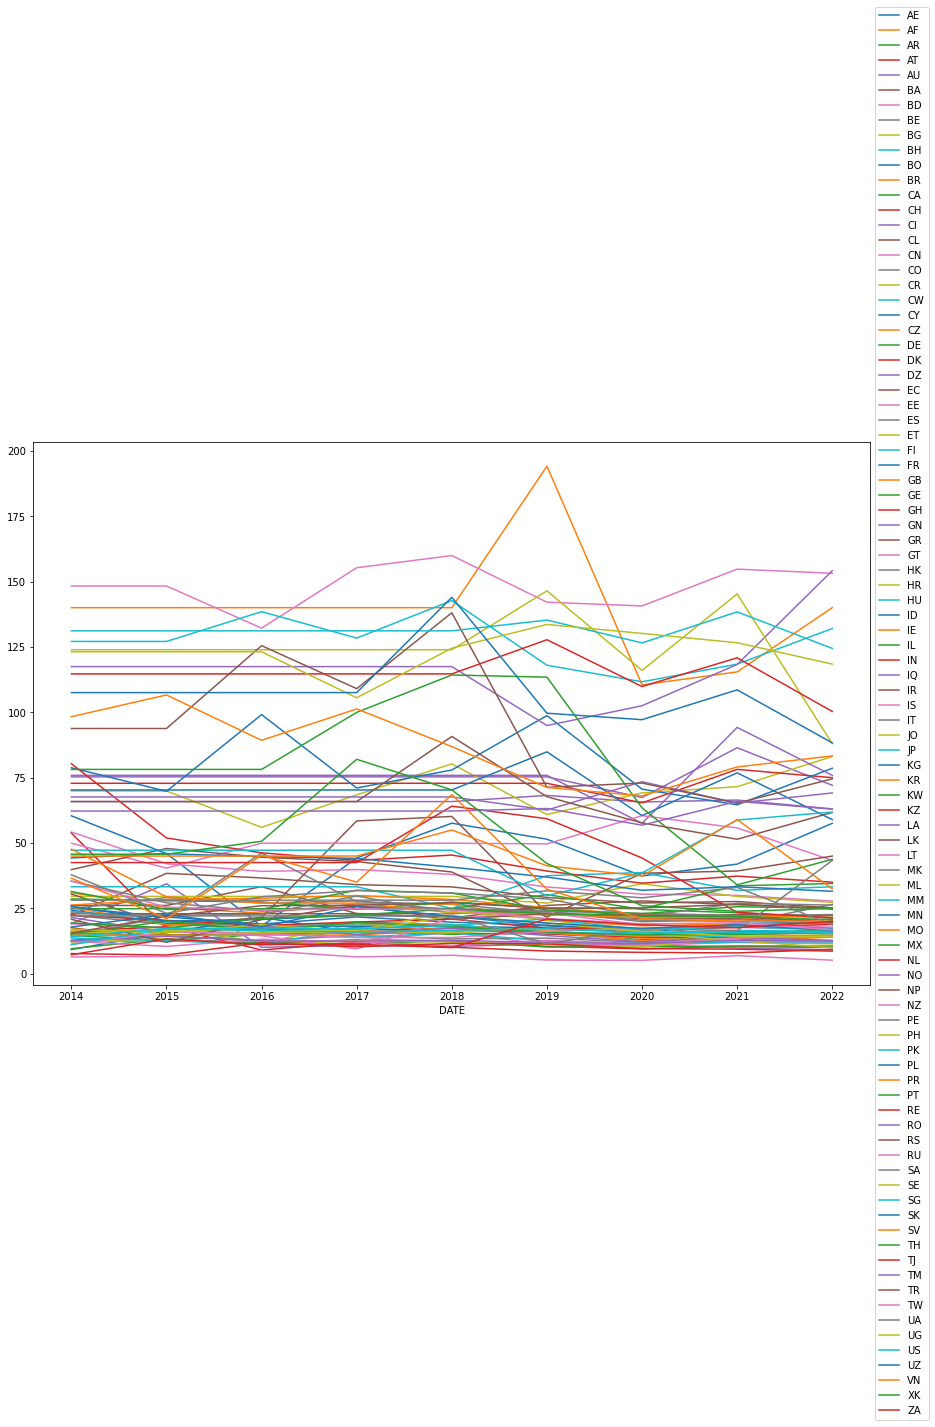

In [62]:
df_by_year_pivot.plot.line(figsize=(15,10))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## Agregando países e geolocalização

In [63]:
df.query('COUNTRY == "BR"')

,DATE,COUNTRY,CITY,SPECIE,COUNT,MIN,MAX,MEDIAN,VARIANCE
293819,2015-01-13,BR,São José dos Campos,pm10,15,1.0,55.0,19.0,3601.43
293820,2015-04-08,BR,São José dos Campos,pm10,23,6.0,23.0,12.0,134.47
293821,2015-04-21,BR,São José dos Campos,pm10,23,1.0,47.0,18.0,1838.77
293822,2015-06-07,BR,São José dos Campos,pm10,23,10.0,28.0,18.0,305.73
293823,2015-06-10,BR,São José dos Campos,pm10,23,11.0,78.0,30.0,3854.74
...,...,...,...,...,...,...,...,...,...
54641,2022-05-17,BR,São Paulo,co,229,1.0,11.8,3.7,39.22
54642,2022-06-25,BR,São Paulo,co,252,1.0,36.2,10.9,686.30
54643,2022-02-22,BR,São Paulo,co,311,1.0,17.2,4.6,77.86
54644,2022-04-14,BR,São Paulo,co,203,1.0,16.3,2.8,144.20


## Agrupar por mês/ano

Usar median